In [497]:
class line_tracker():
    def __init__(self):
        self.left_slopes = []
        self.left_xs = []
        self.right_slopes = []
        self.right_xs = []
        self.index = 0
    def get_line(self, slope, bottom_x, isLeft, top_y, bottom_y):
        slopes = []
        xs = []
        if(isLeft):
            if bottom_x > 0:
                self.left_slopes.append(slope)
                self.left_xs.append(bottom_x)
            slopes = self.left_slopes
            xs = self.left_xs
        else:
            if bottom_x > 0:
                self.right_slopes.append(slope)
                self.right_xs.append(bottom_x)
            slopes = self.right_slopes
            xs = self.right_xs
            
            
        if(len(slopes) > 5):
            length = len(slopes)
            slopes = slopes[length-5:]
            
        if(len(xs) > 5):
            length = len(xs)
            xs = xs[length-5:]
        
        
        
        count = len(slopes)
        if(count > 0):
            sum_slope = 0
            for s in slopes:
                sum_slope += s
            avg_slope = sum_slope / count

            sum_x = 0
            for x in xs:
                sum_x += x
            avg_x = sum_x / count

            #find y-intercept given the bottom point so we can extrapolate a line to find the top x-coordinate
            b = bottom_y - avg_slope * avg_x
            top_x = (top_y - b) / avg_slope



            return int(top_x), int(avg_x)
        else:
            return bottom_y, 0
            
    def get_video_index(self):
        self.index += 1
        return self.index
            

In [498]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 

In [499]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [500]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [501]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [502]:
def draw_lines(img, lines, line_tracker, color=[255, 0, 0], thickness=8):
    imshape = img.shape

    left_slope = 0
    left_xs = 0 #x-coordinates of left line segments when y = 540 (bottom of image)
    left_count = 0
    
    right_slope = 0
    right_xs = 0 #x-coordinates of right line segments when y = 540 (bottom of image)
    right_count = 0
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope != float("Inf") and slope != float("-Inf") and (slope > .3 or slope < -.3): #ignore line segments with a very shallow slope
                b = y1 - slope * x1 #find y-intercept so we can find the x-coordinate when y=540
                if slope < 0:
                    left_slope += slope
                    left_xs += (imshape[0] - b)/slope
                    left_count += 1
                else:
                    right_slope += slope
                    right_xs += (imshape[0] - b)/slope
                    right_count += 1

    #y-coordinates are fixed to the top and bottom of the region of interest
    top_y = int(.61 * imshape[0])
    bottom_y = int(imshape[0])

    bottom_left_x = 0
    bottom_right_x = 0
    
    if left_count > 0:
        left_slope /= left_count
        bottom_left_x = int(left_xs / left_count)
    if right_count > 0:
        right_slope /= right_count
        bottom_right_x = int(right_xs / right_count)

    top_left_x, bottom_left_x = line_tracker.get_line(left_slope, bottom_left_x, True, top_y, bottom_y)
    top_right_x, bottom_right_x = line_tracker.get_line(right_slope, bottom_right_x, False, top_y, bottom_y)
    
    cv2.line(img, (top_left_x, top_y), (bottom_left_x, bottom_y), color, thickness)
    cv2.line(img, (top_right_x, top_y), (bottom_right_x, bottom_y), color, thickness)
    

    
def draw_all_lines(img, lines, color=[255, 0, 0], thickness=6):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


In [503]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, line_tracker):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, line_tracker)
    #draw_all_lines(line_img, lines)
    return line_img

In [504]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [505]:
def process_image(image, line_tracker):
    #reading in an image
    #image = mpimg.imread('test_images/WhiteCarLaneSwitch.jpg')
    #printing out some stats and plotting
    #print('This image is:', type(image), 'with dimesions:', image.shape)
    #plt.imshow(image)  
    gray = grayscale(image)
    #plt.imshow(gray, cmap='Greys_r') #grayscaled image
    #plt.show()

    #apply Gaussian smoothing
    blur_gray = gaussian_blur(gray,7)
    #plt.imshow(blur_gray, cmap='Greys_r')
    #plt.show()
    # Define our parameters for Canny and apply
    edges = canny(blur_gray, 70, 180)
    #plt.imshow(edges, cmap='Greys_r')
    #plt.show()
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    
    vertices = np.array([[(0,imshape[0]),(.47*imshape[1], .61*imshape[0]), (.53*imshape[1], .61*imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    #plt.imshow(masked_edges, cmap='Greys_r')
    #plt.show()
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, 2, np.pi/180, 25, 60, 25, line_tracker) 
    plt.imshow(line_image)
    plt.show()
    # Draw the lines on the original image
    original_with_lines = weighted_img(line_image, image, .8,1.0)
    plt.imshow(original_with_lines)
    plt.show()
    return original_with_lines

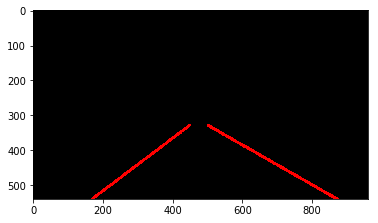

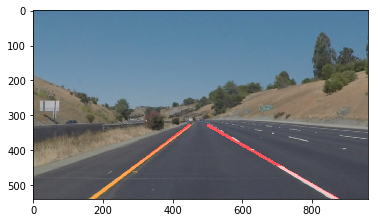

array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ..., 
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ..., 
       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ..., 
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ..., 
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ..., 
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,

In [506]:

   



video_line_tracker = line_tracker()

def process(img):
    #write_name = './challenge_video_images/challenge' + str(video_line_tracker.get_video_index()) + '.jpg'
    #cv2.imwrite(write_name, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    processed = process_image(img, video_line_tracker)
    return processed

import glob

def process_test_images():
    images = glob.glob('./test_images/*.jpg')
    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        #image_line_tracker = line_tracker()
        process_image(img, video_line_tracker)

        
#process_test_images()

process(mpimg.imread('test_images/solidYellowCurve2.jpg'))

#white_output = 'results/white.mp4'
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)

#yellow_output = 'results/yellow.mp4'
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
#yellow_clip = clip2.fl_image(process)
#%time yellow_clip.write_videofile(yellow_output, audio=False)

#challenge_output = 'results/extra.mp4'
#clip2 = VideoFileClip('test_videos/challenge.mp4')
#challenge_clip = clip2.fl_image(process)
#%time challenge_clip.write_videofile(challenge_output, audio=False)

#HTML("""
#<video width="960" height="540" controls>
# <source src="{0}">
#</video>
#""".format(white_output))

